In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import permutations
import statistics

df = pd.read_csv('/Users/peterchen/Desktop/RvR_raw_data/Scatter Plot (Raw)_grouped.csv', 
                 converters={'Speed': lambda x: 'Running' if float(x)>0 else 'Resting'})
mice = np.sort(df['Mouse ID'].unique())
laserPowers = np.sort(df['Laser'].unique())
groups = list(itertools.product(mice, laserPowers))

In [2]:
states = df['Speed'].unique()
features = ['Fit Lifetime', 'Empirical Lifetime', 'Intensity']

featureCombinations = list(itertools.product(states, features))
columns = [str[0]+ ' ' +str[1] for str in featureCombinations]
print(featureCombinations)

keys = ['Mouse ID', 'Laser'] + columns
summary = {key:[] for key in keys}


for group in groups:
    summary['Mouse ID'].append(group[0])
    summary['Laser'].append(group[1])
    for featureSet in featureCombinations:
        rows = df.loc[(df['Mouse ID'] == group[0]) & (df['Laser'] == group[1]) & (df['Speed'] == featureSet[0])]
        try:
            summary[columns[featureCombinations.index(featureSet)]].append(statistics.mean(rows[featureSet[1]]))
        except:
            summary[columns[featureCombinations.index(featureSet)]].append(np.nan)
            
outputDF = pd.DataFrame(summary)
outputDF.to_csv('RvR_Aggregated.csv')

[('Resting', 'Fit Lifetime'), ('Resting', 'Empirical Lifetime'), ('Resting', 'Intensity'), ('Running', 'Fit Lifetime'), ('Running', 'Empirical Lifetime'), ('Running', 'Intensity')]


Mouse ID: 1610


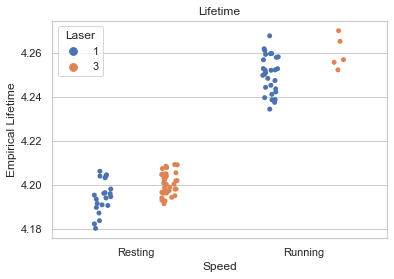

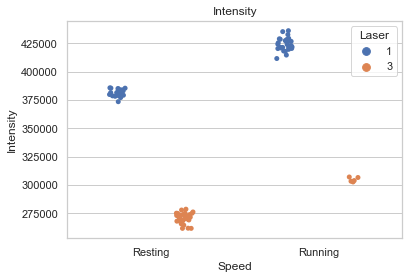

Mouse ID: 1611


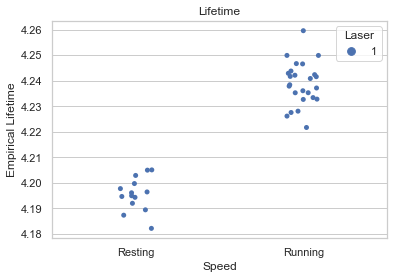

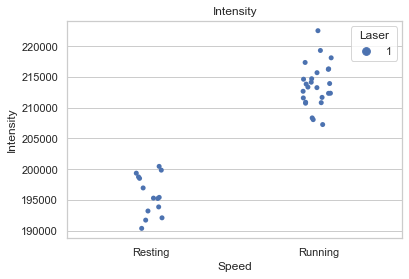

Mouse ID: 1612


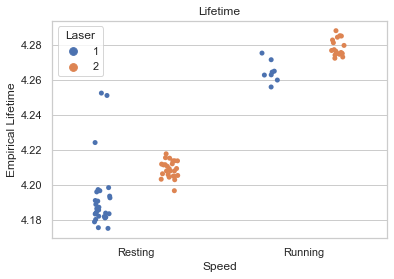

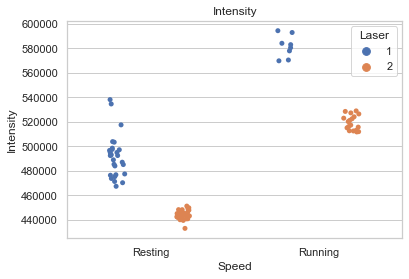

Mouse ID: 1626


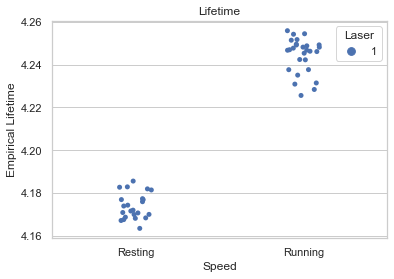

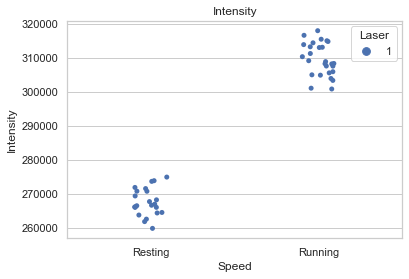

Mouse ID: 1627


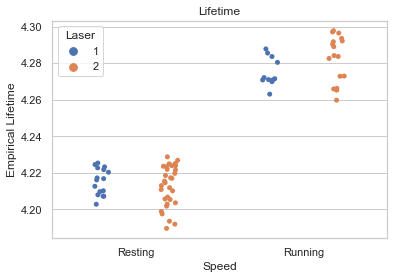

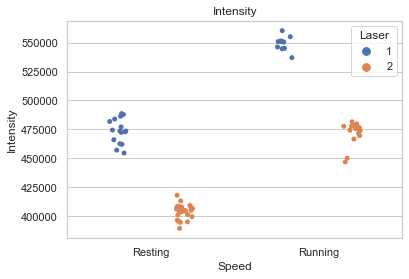

Mouse ID: 1629


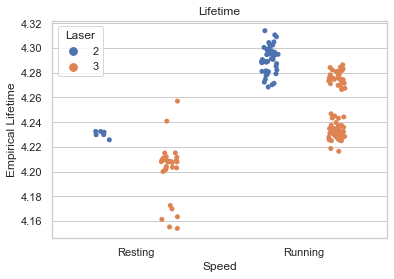

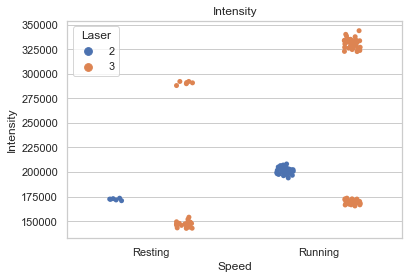

Mouse ID: 1630


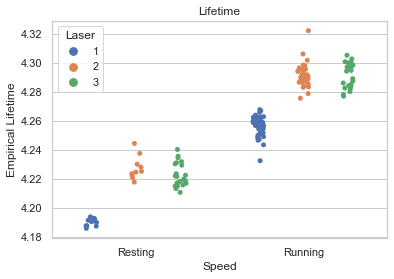

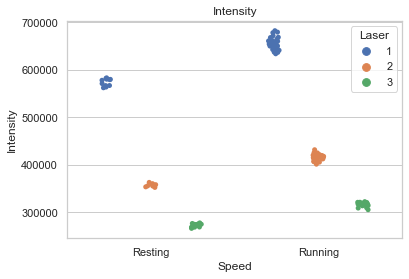

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#Scatter Plots by Mouse
for mouse in mice:
    print('Mouse ID: ' + str(mouse))
    rows = df.loc[(df['Mouse ID'] == mouse)]
    
    sns.set(style = 'whitegrid')      
    sns.stripplot(x="Speed", y="Empirical Lifetime", data=rows, hue = 'Laser', dodge = True)
    plt.title('Lifetime')
    plt.show()
    sns.stripplot(x="Speed", y="Intensity", data=rows, hue = 'Laser', dodge = True)
    plt.title('Intensity')
    plt.show()

Laser Power: 1


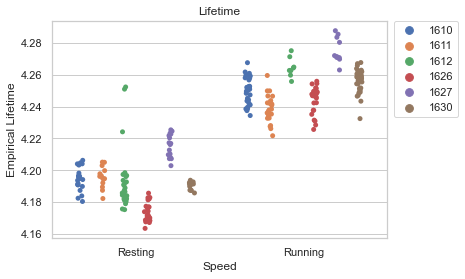

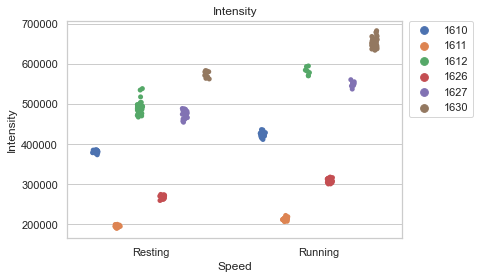

Laser Power: 2


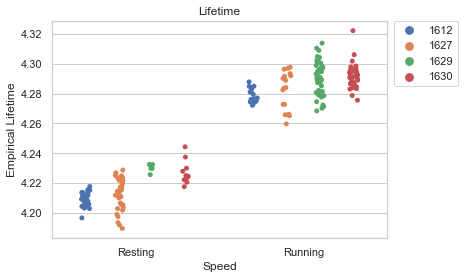

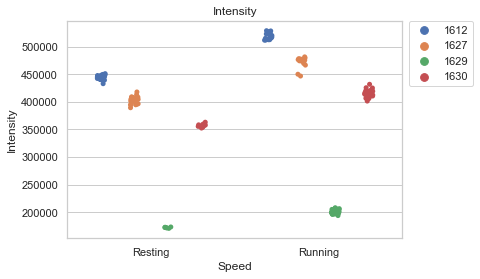

Laser Power: 3


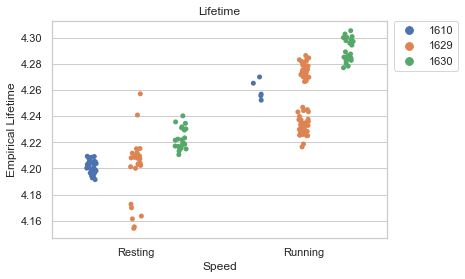

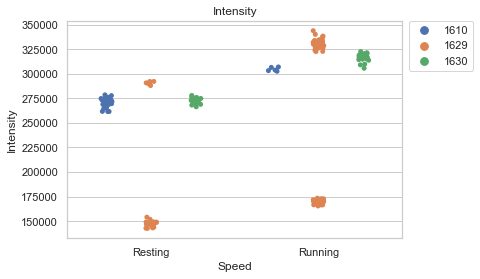

In [4]:
#Scatter Plots by Laser
for laser in laserPowers:
    print('Laser Power: ' + str(laser))
    rows = df.loc[(df['Laser'] == laser)]
    
    sns.set(style = 'whitegrid')      
    sns.stripplot(x="Speed", y="Empirical Lifetime", data=rows, hue = 'Mouse ID', dodge = True)
    plt.title('Lifetime')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    sns.stripplot(x="Speed", y="Intensity", data=rows, hue = 'Mouse ID', dodge = True)
    plt.title('Intensity')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
            

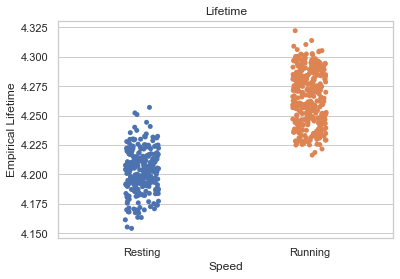

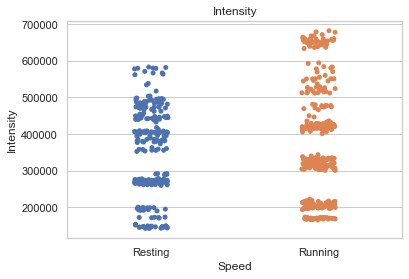

In [5]:
#All Grouped

sns.set(style = 'whitegrid')      
sns.stripplot(x="Speed", y="Empirical Lifetime", data=df, dodge = True)
plt.title('Lifetime')
plt.show()

sns.stripplot(x="Speed", y="Intensity", data=df, dodge = True)
plt.title('Intensity')
plt.show()

In [6]:
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm


def integer_encoding(df, cols, centered = True):
    print('Encoding:')
    for col in cols:
        #create bins
        uniqueValues = np.sort(df[col].unique())
        if (centered == True) and len(uniqueValues) % 2 == 1:
            integer_bins = [*range(-(len(uniqueValues)//2),(len(uniqueValues)//2)+1)]
        elif (centered == True) and len(uniqueValues) % 2 == 0:
            integer_bins = [*range(-(len(uniqueValues)//2),0)]+[*range(1,(len(uniqueValues)//2)+1)]
        else:
            integer_bins = [*range(len(uniqueValues))]
            
        integer_dict = {val: integer_bins[list(uniqueValues).index(val)] for val in uniqueValues}

        df[col] = df[col].replace(integer_dict)
        print(integer_dict)
    return df

def linear_RFE(X, y):
    rfe = RFE(LinearRegression(), importance_getter='auto')
    rfe = rfe.fit(X, y)
    rfe_ranking = [x for _, x in sorted(zip(rfe.ranking_, X.columns))]
    print('\nRFE Order:')
    print(rfe_ranking)
    return rfe_ranking

def incremental_rSquared(X, y, featureRank, adjusted = True):
    print('\nIncremental R Squared:')
    increments = []
    rSquared = []
    rSquared_adjusted = []
    for feature in range(len(featureRank)):
        
        X_temp = X[featureRank[0:feature+1]].copy()
        model = LinearRegression()
        model.fit(X_temp, y)
        r_squared, adjusted_r_squared = calculate_rSquared(model, X_temp, y)
        
        rSquared.append(r_squared)
        rSquared_adjusted.append(adjusted_r_squared)
        
        if adjusted:
            increments.append(adjusted_r_squared-sum(increments))
        else:
            increments.append(r_squared-sum(increments))
    contribution = {featureRank[idx]:increments[idx]/rSquared[-1] for idx in range(len(increments))}
    return contribution, rSquared, rSquared_adjusted


def calculate_rSquared(model, X, y):
#     yhat = model.predict(X)
#     SS_Residual = sum((y-yhat)**2)       
#     SS_Total = sum((y-np.mean(y))**2)     
#     r_squared = 1 - (float(SS_Residual))/SS_Total
    r_squared = model.score(X,y)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return r_squared, adjusted_r_squared



In [7]:
# RVR Data
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors

df_categorical = df.copy(deep=True)
df_categorical = integer_encoding(df_categorical, ['Mouse ID', 'Speed', 'Laser'])

print('\n\nIntensity Data')
X = df_categorical.drop(['Intensity', 'Fit Lifetime', 'Empirical Lifetime', 'Dataset'], axis=1)
y = df_categorical['Intensity']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)


print('\n\nLifetime Data')

y = df_categorical['Empirical Lifetime']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)

Encoding:
{1610: -3, 1611: -2, 1612: -1, 1626: 0, 1627: 1, 1629: 2, 1630: 3}
{'Resting': -1, 'Running': 1}
{1: -1, 2: 0, 3: 1}


Intensity Data

RFE Order:
['Laser', 'Mouse ID', 'Speed']

Incremental R Squared:

R^2 Values:
[0.24273239228302956, 0.2897633537985579, 0.2905868099162807]

Adjusted R^2 Values:
[0.24151295974242248, 0.28747226784306934, 0.28714861998049523]

Contribution:
{'Laser': 0.831121549570689, 'Mouse ID': 0.15816033808928878, 'Speed': -0.0011137734113511554}


Lifetime Data

RFE Order:
['Speed', 'Laser', 'Mouse ID']

Incremental R Squared:

R^2 Values:
[0.6951513470100232, 0.7193468868107677, 0.7469426940446592]

Adjusted R^2 Values:
[0.6946604474077849, 0.7184415541875767, 0.7457162450658772]

Contribution:
{'Speed': 0.9300050096831814, 'Laser': 0.031837926750469, 'Mouse ID': 0.036515104968239696}


In [8]:
#RvR Data
#Logistic regression to find pseudo R^2 for using Intensity/Lifetime to predict State

import statsmodels.formula.api as smf

df_categorical['emp_lft'] = df_categorical['Empirical Lifetime'].copy()
df_categorical['Speed_binary'] = df_categorical['Speed'].copy()
df_categorical['Speed_binary'] = [0 if point == -1 else 1 for point in df_categorical['Speed_binary']]

print('Intensity')    
log_reg = smf.logit('Speed_binary ~ Intensity', data = df_categorical).fit()
print(log_reg.summary())

print('Lifetime')    
log_reg = smf.logit('Speed_binary ~ emp_lft', data = df_categorical).fit()
print(log_reg.summary())

Intensity
Optimization terminated successfully.
         Current function value: 0.680959
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           Speed_binary   No. Observations:                  623
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Dec 2022   Pseudo R-squ.:                0.006610
Time:                        12:16:58   Log-Likelihood:                -424.24
converged:                       True   LL-Null:                       -427.06
Covariance Type:            nonrobust   LLR p-value:                   0.01750
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2538      0.227     -1.119      0.263      -0.698       0.191
Intensity   1.407e-

In [9]:
# Sleep Data
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors

df_sleep = pd.read_csv('/Users/peterchen/Desktop/sleep_wake_all_table.csv')
df_sleep_categorical = integer_encoding(df_sleep, ['Mouse_ID', 'Time', 'State'])

print('\n\nIntensity Data')
X = df_sleep_categorical.drop(['Intensity', 'Lifetime'], axis=1)
y = df_sleep_categorical['Intensity']

print(X)
featureRank = linear_RFE(X, y)
contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)


print('\n\nLifetime Data')

y = df_sleep_categorical['Lifetime']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)

Encoding:
{1610: -3, 1611: -2, 1612: -1, 1626: 0, 1627: 1, 1629: 2, 1630: 3}
{1: -1, 2: 0, 3: 1}
{2: -1, 3: 1}


Intensity Data
     Mouse_ID  Time  State
0          -3     0     -1
1          -3     0     -1
2          -3     0     -1
3          -3     0     -1
4          -3     0     -1
..        ...   ...    ...
807         3     1      1
808         3     1      1
809         3     1      1
810         3     1      1
811         3     1      1

[812 rows x 3 columns]

RFE Order:
['Time', 'Mouse_ID', 'State']

Incremental R Squared:

R^2 Values:
[0.16257313674857066, 0.2702621400311137, 0.28448351721467324]

Adjusted R^2 Values:
[0.1615392764235689, 0.26845809093353923, 0.28182689661027227]

Contribution:
{'Time': 0.5678335181073786, 'Mouse_ID': 0.37583483063199274, 'State': 0.04699325221940661}


Lifetime Data

RFE Order:
['State', 'Time', 'Mouse_ID']

Incremental R Squared:

R^2 Values:
[0.4965540999085243, 0.511102417437824, 0.5146922651228143]

Adjusted R^2 Values:
[0.4959325617

In [10]:
df_sleep_categorical['State_01'] = df_sleep_categorical['State'].copy()
df_sleep_categorical['State_01'] = [0 if point == -1 else 1 for point in df_sleep_categorical['State_01']]

print('Intensity')    
log_reg = smf.logit('State_01 ~ Intensity', data = df_sleep_categorical).fit()
print(log_reg.summary())

print('Lifetime')    
log_reg = smf.logit('State_01 ~ Lifetime', data = df_sleep_categorical).fit()
print(log_reg.summary())

Intensity
Optimization terminated successfully.
         Current function value: 0.602502
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               State_01   No. Observations:                  812
Model:                          Logit   Df Residuals:                      810
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Dec 2022   Pseudo R-squ.:                0.009250
Time:                        12:17:06   Log-Likelihood:                -489.23
converged:                       True   LL-Null:                       -493.80
Covariance Type:            nonrobust   LLR p-value:                  0.002508
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4743      0.220     -6.705      0.000      -1.905      -1.043
Intensity      0.21